# Smile classification from face images using CNN

This notebook will go over data preparation, creation and training of the CNN smile classifier, and finally the evaluation of the classifier. For this notebook, we will use well-known CelebA dataset, and for model creation we will use PyTorch. The goal of this notebook is not necessarily creation of the best possible model, but rather to show one of many approaches to solving this type of problem.

**Imports**

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import torch
import torch.nn as nn
import torchvision 
from torch.utils.data import DataLoader
from torchvision import transforms 
from IPython.display import Image

## Preparing the data

First, let's create a function for extracting the smile label from `attributes` list. Then, we can define a data transformation pipelines for preprocessing images, one for training dataset and one for validation and test dataset.

In [2]:
get_smile = lambda attr: attr[31]
 
transform_train = transforms.Compose([
    transforms.RandomCrop([178, 178]),
    transforms.RandomHorizontalFlip(),
    transforms.Resize([64, 64]),
    transforms.ToTensor(),
])

transform = transforms.Compose([
    transforms.CenterCrop([178, 178]),
    transforms.Resize([64, 64]),
    transforms.ToTensor(),
])

Now we can load the CelebA dataset and apply transformations. In order to get required files, you can set `download=True` in the code below, or you can download the files directly from the official [CelebA website](https://mmlab.ie.cuhk.edu.hk/projects/CelebA.html).

In [3]:
image_path = './'

celeba_train_dataset = torchvision.datasets.CelebA(image_path, 
                                                   split='train', 
                                                   target_type='attr', 
                                                   download=False, 
                                                   transform=transform_train,
                                                   target_transform=get_smile)

celeba_valid_dataset = torchvision.datasets.CelebA(image_path, 
                                                   split='valid', 
                                                   target_type='attr', 
                                                   download=False, 
                                                   transform=transform,
                                                   target_transform=get_smile)

celeba_test_dataset = torchvision.datasets.CelebA(image_path, 
                                                   split='test', 
                                                   target_type='attr', 
                                                   download=False, 
                                                   transform=transform,
                                                   target_transform=get_smile)

print('Train set:', len(celeba_train_dataset))
print('Validation set:', len(celeba_valid_dataset))
print('Test set:', len(celeba_test_dataset))

Train set: 162770
Validation set: 19867
Test set: 19962


Let's set up data loaders for training, validation, and test datasets so we can load and process data in batches, and then we can finally create our CNN model and train it.

In [4]:
batch_size = 32
torch.manual_seed(1)

train_dl = DataLoader(celeba_train_dataset, batch_size, shuffle=True)
valid_dl = DataLoader(celeba_valid_dataset, batch_size, shuffle=False)
test_dl = DataLoader(celeba_test_dataset, batch_size, shuffle=False)

## Creating and training a CNN Smile classifier

Now we will create our model and add all the layers to it.

In [5]:
model = nn.Sequential()

model.add_module('conv1', nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1))
model.add_module('relu1', nn.ReLU())        
model.add_module('pool1', nn.MaxPool2d(kernel_size=2))  
model.add_module('dropout1', nn.Dropout(p=0.4)) 

model.add_module('conv2', nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1))
model.add_module('relu2', nn.ReLU())        
model.add_module('pool2', nn.MaxPool2d(kernel_size=2))   
model.add_module('dropout2', nn.Dropout(p=0.4))

model.add_module('conv3', nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1))
model.add_module('relu3', nn.ReLU())        
model.add_module('pool3', nn.MaxPool2d(kernel_size=2))
model.add_module('dropout3', nn.Dropout(p=0.4))

model.add_module('conv4', nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1))
model.add_module('relu4', nn.ReLU()) 

model.add_module('conv5', nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1))
model.add_module('relu5', nn.ReLU())

model.add_module('pool4', nn.AvgPool2d(kernel_size=8)) 
model.add_module('flatten', nn.Flatten())

model.add_module('fc', nn.Linear(512, 1)) 
model.add_module('sigmoid', nn.Sigmoid())

model

Sequential(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.4, inplace=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout2): Dropout(p=0.4, inplace=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3): ReLU()
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout3): Dropout(p=0.4, inplace=False)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu4): ReLU()
  (conv5): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu5): ReLU()
  (pool4): AvgPool2d(kernel_size=8, stride=8, padding=0)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc): Linear(i

We can finally train our model! During the training we will monitor training and validation accuracy for every epoch to see progress.

In [6]:
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

def train(model, num_epochs, train_dl, valid_dl):
    loss_hist_train = [0] * num_epochs
    accuracy_hist_train = [0] * num_epochs
    loss_hist_valid = [0] * num_epochs
    accuracy_hist_valid = [0] * num_epochs
    for epoch in range(num_epochs):
        model.train()
        for x_batch, y_batch in train_dl: 
            pred = model(x_batch)[:, 0]
            loss = loss_fn(pred, y_batch.float())
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            loss_hist_train[epoch] += loss.item()*y_batch.size(0)
            is_correct = ((pred>=0.5).float() == y_batch).float()
            accuracy_hist_train[epoch] += is_correct.sum().cpu()

        loss_hist_train[epoch] /= len(train_dl.dataset)
        accuracy_hist_train[epoch] /= len(train_dl.dataset)
        
        model.eval()
        with torch.no_grad():
            for x_batch, y_batch in valid_dl: 
                pred = model(x_batch)[:, 0]
                loss = loss_fn(pred, y_batch.float())
                loss_hist_valid[epoch] += loss.item()*y_batch.size(0) 
                is_correct = ((pred>=0.5).float() == y_batch).float()
                accuracy_hist_valid[epoch] += is_correct.sum().cpu()

        loss_hist_valid[epoch] /= len(valid_dl.dataset)
        accuracy_hist_valid[epoch] /= len(valid_dl.dataset)
        
        print(f'Epoch {epoch+1} - Train Accuracy: {accuracy_hist_train[epoch]:.4f} Val Accuracy: {accuracy_hist_valid[epoch]:.4f}')
    return loss_hist_train, loss_hist_valid, accuracy_hist_train, accuracy_hist_valid

torch.manual_seed(1)
num_epochs = 30
hist = train(model, num_epochs, train_dl, valid_dl)

Epoch 1 - Train Accuracy: 0.6454 Val Accuracy: 0.8285
Epoch 2 - Train Accuracy: 0.8335 Val Accuracy: 0.8925
Epoch 3 - Train Accuracy: 0.8748 Val Accuracy: 0.9011
Epoch 4 - Train Accuracy: 0.8852 Val Accuracy: 0.9089
Epoch 5 - Train Accuracy: 0.8903 Val Accuracy: 0.9120
Epoch 6 - Train Accuracy: 0.8937 Val Accuracy: 0.9147
Epoch 7 - Train Accuracy: 0.8963 Val Accuracy: 0.9173
Epoch 8 - Train Accuracy: 0.8986 Val Accuracy: 0.9141
Epoch 9 - Train Accuracy: 0.9001 Val Accuracy: 0.9167
Epoch 10 - Train Accuracy: 0.9020 Val Accuracy: 0.9143
Epoch 11 - Train Accuracy: 0.9023 Val Accuracy: 0.9154
Epoch 12 - Train Accuracy: 0.9035 Val Accuracy: 0.9202
Epoch 13 - Train Accuracy: 0.9044 Val Accuracy: 0.9174
Epoch 14 - Train Accuracy: 0.9045 Val Accuracy: 0.9139
Epoch 15 - Train Accuracy: 0.9060 Val Accuracy: 0.9209
Epoch 16 - Train Accuracy: 0.9060 Val Accuracy: 0.9165
Epoch 17 - Train Accuracy: 0.9076 Val Accuracy: 0.9202
Epoch 18 - Train Accuracy: 0.9075 Val Accuracy: 0.9156
Epoch 19 - Train Ac

## Evaluating the model

Let's visualize the learning curve and compare the loss and accuracy of training and validation after each epoch.

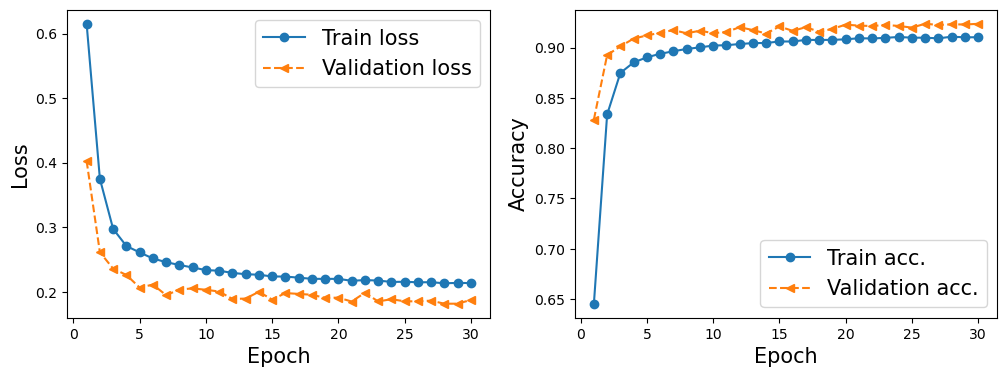

In [7]:
x_arr = np.arange(len(hist[0])) + 1

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist[0], '-o', label='Train loss')
ax.plot(x_arr, hist[1], '--<', label='Validation loss')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)

ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist[2], '-o', label='Train acc.')
ax.plot(x_arr, hist[3], '--<', label='Validation acc.')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)

plt.show()

Now we will evaluate the model on the test dataset and see how our model performs.

In [8]:
accuracy_test = 0

model.eval()
with torch.no_grad():
    for x_batch, y_batch in test_dl:
        pred = model(x_batch)[:, 0]
        is_correct = ((pred>=0.5).float() == y_batch).float()
        accuracy_test += is_correct.sum()
 
accuracy_test /= len(test_dl.dataset)
        
print(f'Test accuracy: {accuracy_test:.4f}') 

Test accuracy: 0.9237


Not bad, now let's plot 10 images that our model estimated correctly and then 10 images that our model struggled with. We will plot the images with the true labels and the predicted probability of the 'Smile' label.

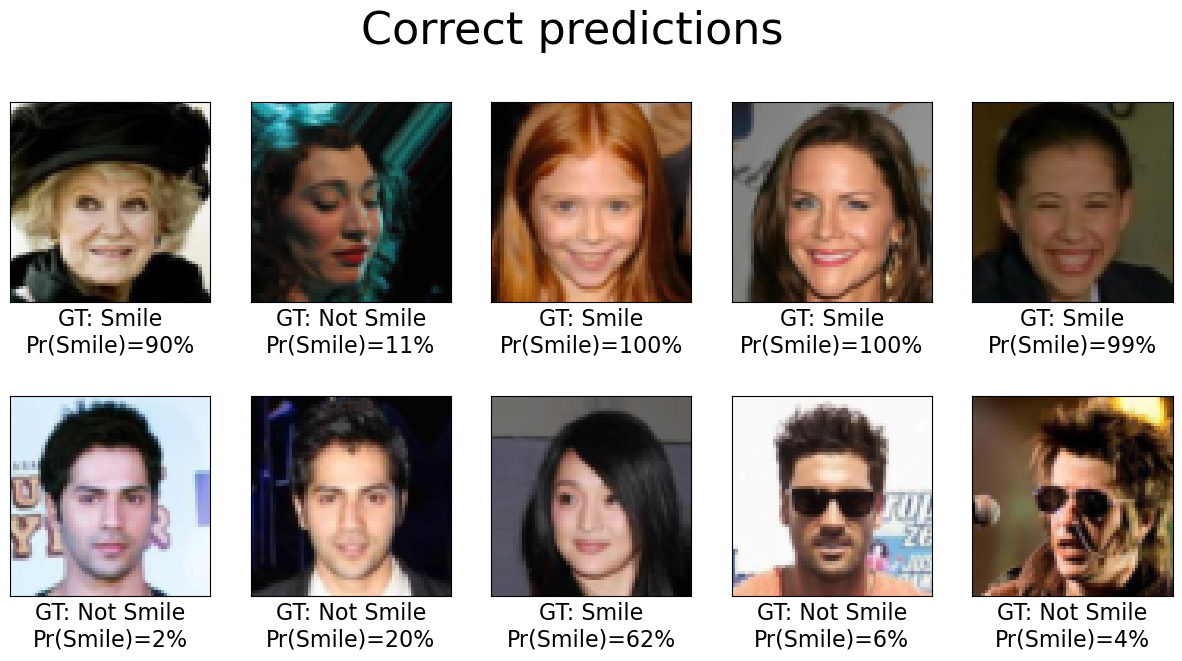

In [9]:
fig = plt.figure(figsize=(15, 7))
i = 0
for x_batch, y_batch in test_dl:
    pred = model(x_batch)[:, 0] * 100
    for j in range(len(y_batch)):
        if ((y_batch[j] == 1 and pred[j] > 50) or (y_batch[j] == 0 and pred[j] < 50)):
            i += 1
            ax = fig.add_subplot(2, 5, i)
            ax.set_xticks([]); ax.set_yticks([])
            ax.imshow(x_batch[j].permute(1, 2, 0))
            if y_batch[j] == 1:
                label = 'Smile'
            else:
                label = 'Not Smile'
            ax.text(
                0.5, -0.15, 
                f'GT: {label:s}\nPr(Smile)={pred[j]:.0f}%', 
                size=16, 
                horizontalalignment='center',
                verticalalignment='center', 
                transform=ax.transAxes)
            if i == 10:
                break
    if i == 10:
        break

fig.suptitle('Correct predictions', fontsize=32)
plt.show()

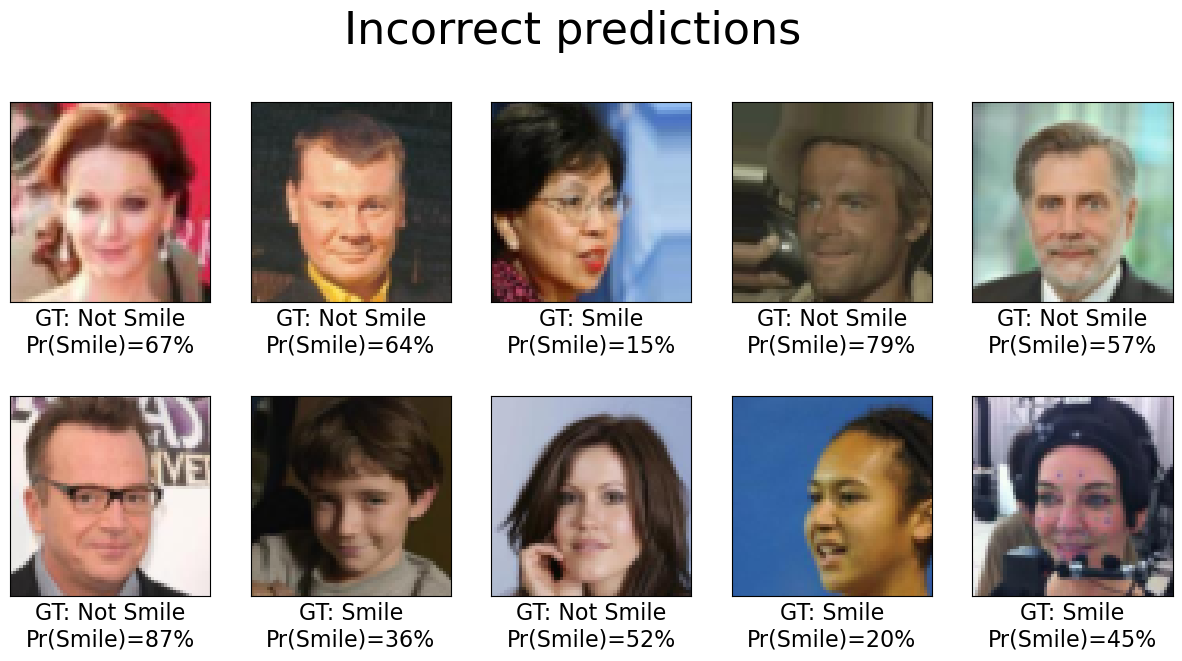

In [10]:
fig = plt.figure(figsize=(15, 7))
i = 0
for x_batch, y_batch in test_dl:
    pred = model(x_batch)[:, 0] * 100
    for j in range(len(y_batch)):
        if ((y_batch[j] == 1 and pred[j] < 50) or (y_batch[j] == 0 and pred[j] > 50)):
            i += 1
            ax = fig.add_subplot(2, 5, i)
            ax.set_xticks([]); ax.set_yticks([])
            ax.imshow(x_batch[j].permute(1, 2, 0))
            if y_batch[j] == 1:
                label = 'Smile'
            else:
                label = 'Not Smile'
            ax.text(
                0.5, -0.15, 
                f'GT: {label:s}\nPr(Smile)={pred[j]:.0f}%', 
                size=16, 
                horizontalalignment='center',
                verticalalignment='center', 
                transform=ax.transAxes)
            if i == 10:
                break
    if i == 10:
        break
        
fig.suptitle('Incorrect predictions', fontsize=32)
plt.show()

Finally we can save the model.

In [11]:
if not os.path.exists('models'):
    os.mkdir('models')

path = 'models/celeba-cnn.ph'
torch.save(model, path)